In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn.metrics import (
    classification_report, roc_auc_score, accuracy_score, 
    f1_score, roc_curve
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from pygam import s, te, f, LogisticGAM
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.stats import ortho_group

import xgboost as xgb

from src.data_generation import *
from src.analysis import ModelEvaluator
from src.utils import *
from src.plotting import visualize_feature_shifts
from src.grid_search import *

from sklearn import datasets


np.random.seed(0)

GRID_SEARCH = False
PLOT = True
GEN_DATA = True
OVERFIT = False

# Iris Dataset (Binary)

In [2]:
iris = datasets.load_iris()
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [3]:
# Convert iris dataset to pandas DataFrame
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target
iris_df['target'].describe()

count    150.000000
mean       1.000000
std        0.819232
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: target, dtype: float64

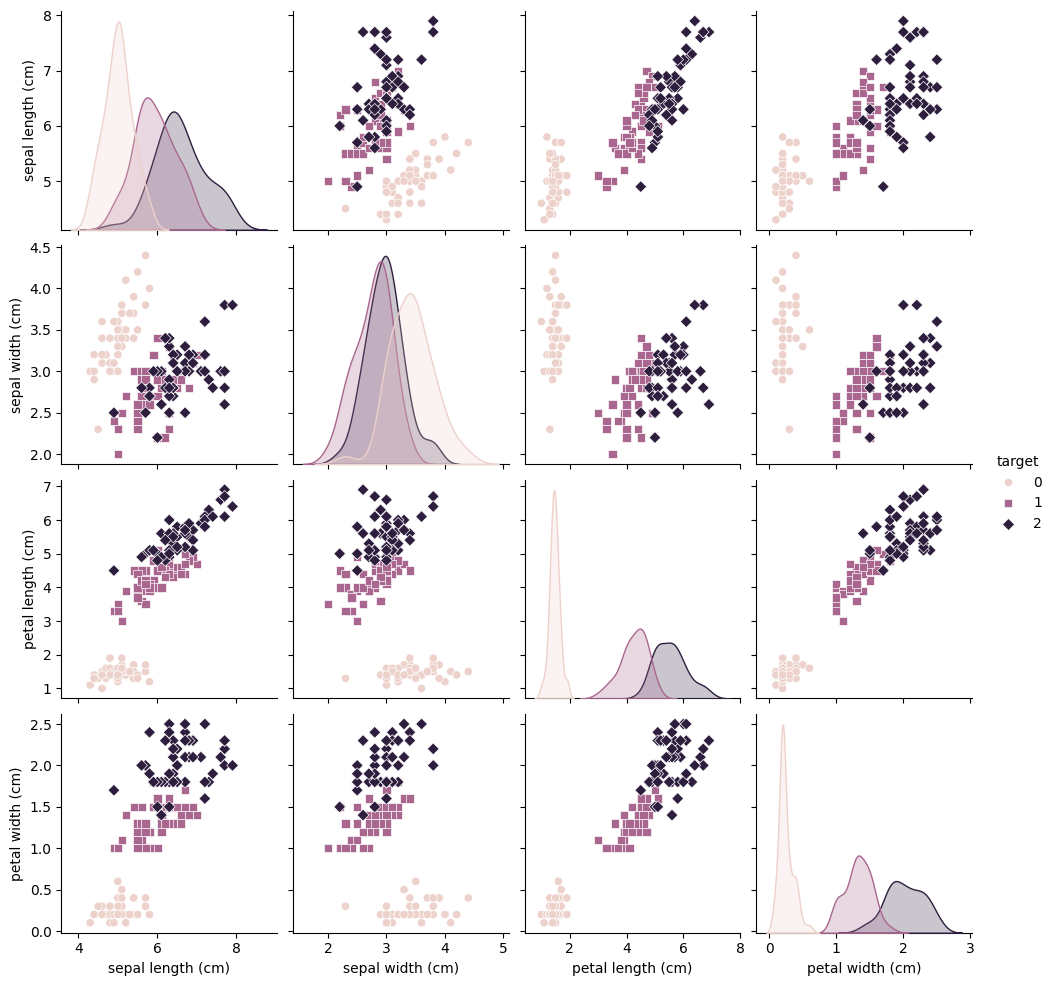

In [4]:
sns.pairplot(iris_df, hue='target', markers=["o", "s", "D"])
plt.show()

In [5]:
iris_df = iris_df[iris_df['target'] != 0]
iris_df.reset_index(drop=True, inplace=True)
print(iris_df)

    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                 7.0               3.2                4.7               1.4   
1                 6.4               3.2                4.5               1.5   
2                 6.9               3.1                4.9               1.5   
3                 5.5               2.3                4.0               1.3   
4                 6.5               2.8                4.6               1.5   
..                ...               ...                ...               ...   
95                6.7               3.0                5.2               2.3   
96                6.3               2.5                5.0               1.9   
97                6.5               3.0                5.2               2.0   
98                6.2               3.4                5.4               2.3   
99                5.9               3.0                5.1               1.8   

    target  
0        1  
1        1  


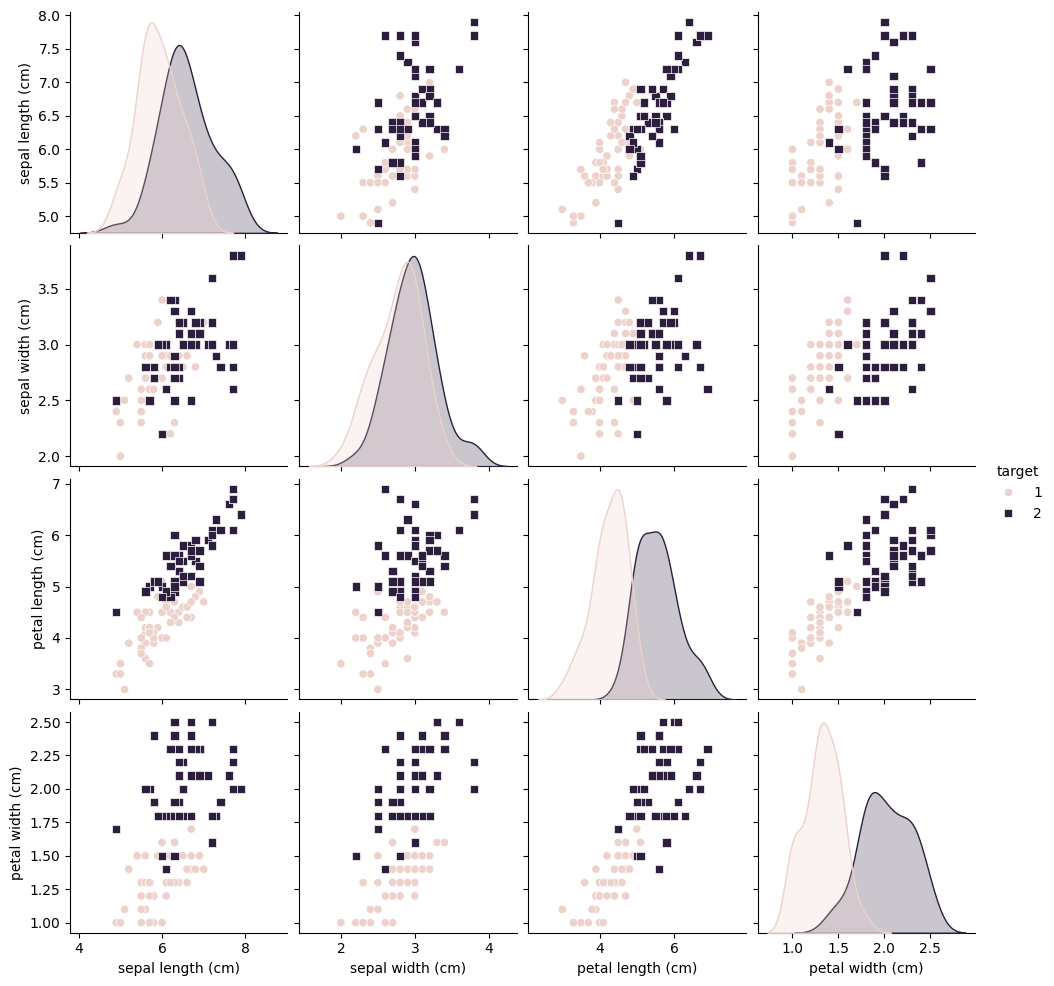

In [6]:
sns.pairplot(iris_df, hue='target', markers=["o", "s"])
plt.show()

define the shift in the quantiles of the variables $\pm$ ??

In [7]:
# feature_ranges = {}

# for features in iris_df.columns:
#     if features != 'target':
#         feature_ranges[features] = (np.quantile(iris_df[features], 0.20),np.quantile(iris_df[features], 0.30))

# print(feature_ranges)

In [12]:
# Define range restrictions for each feature
feature_ranges = {
    'sepal length (cm)': (min(iris_df['sepal length (cm)']), np.quantile(iris_df['sepal length (cm)'], 0.25)),
    'sepal width (cm)': (min(iris_df['sepal width (cm)']), max(iris_df['sepal width (cm)'])),
    'petal length (cm)': (min(iris_df['petal length (cm)']), max(iris_df['petal length (cm)'])),
    'petal width (cm)': (min(iris_df['petal width (cm)']), max(iris_df['petal width (cm)']))
}

In [31]:
# # Filter the dataset based on the specified ranges
# filtered_df = iris_df.copy()
# for feature, (lower, upper) in feature_ranges.items():
#     filtered_df = filtered_df[(filtered_df[feature] >= lower) & (filtered_df[feature] <= upper)]

# # Perform bootstrap sampling on the filtered data
# bootstrap_sample = filtered_df.sample(n=len(filtered_df), replace=True, random_state=42)

# # Identify out-of-bag (OOB) samples
# # OOB samples are those not in the bootstrap sample
# bootstrap_indices = bootstrap_sample.index
# oob_indices = filtered_df.index.difference(bootstrap_indices)

# # Extract the OOB dataset
# oob_samples = filtered_df.loc[oob_indices]

# # Show the results
# print("Original filtered dataset size:", len(filtered_df))
# print("Bootstrap sample size:", len(bootstrap_sample))
# print("Out-of-bag sample size:", len(oob_samples))

Original filtered dataset size: 30
Bootstrap sample size: 30
Out-of-bag sample size: 11


In [32]:
filtered_df = iris_df.copy()
for feature, (lower, upper) in feature_ranges.items():
    filtered_df = filtered_df[(filtered_df[feature] >= lower) & (filtered_df[feature] <= upper)]

# Rows excluded during filtering (not in the filtered dataset)
excluded_rows = iris_df.loc[iris_df.index.difference(filtered_df.index)]

# Perform bootstrap sampling on the filtered data
bootstrap_sample = filtered_df.sample(n=len(filtered_df), replace=True, random_state=42)

# Identify out-of-bag (OOB) samples from the filtered dataset
bootstrap_indices = bootstrap_sample.index
oob_indices = filtered_df.index.difference(bootstrap_indices)
oob_samples = filtered_df.loc[oob_indices]

# Combine OOB samples with the excluded rows from the original dataset
oob_with_excluded = pd.concat([oob_samples, excluded_rows], ignore_index=True)

# Show the results
print("Original dataset size:", len(iris_df))
print("Filtered dataset size:", len(filtered_df))
print("Bootstrap sample size:", len(bootstrap_sample))
print("OOB samples size (filtered):", len(oob_samples))
print("Excluded rows size (not filtered):", len(excluded_rows))
print("Combined OOB + Excluded size:", len(oob_with_excluded))

Original dataset size: 100
Filtered dataset size: 30
Bootstrap sample size: 30
OOB samples size (filtered): 11
Excluded rows size (not filtered): 70
Combined OOB + Excluded size: 81


In [14]:
bootstrap_sample

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
16,5.6,3.0,4.5,1.5,1
44,5.6,2.7,4.2,1.3,1
71,5.6,2.8,4.9,2.0,2
38,5.6,3.0,4.1,1.3,1
30,5.5,2.4,3.8,1.1,1
17,5.8,2.7,4.1,1.0,1
71,5.6,2.8,4.9,2.0,2
45,5.7,3.0,4.2,1.2,1
16,5.6,3.0,4.5,1.5,1
56,4.9,2.5,4.5,1.7,2


In [21]:
# # Parameters
# n_samples = len(iris_df)    
# df_dict = {}                

# for mixing_prob in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:  # Mixing probability for the original dataset
#     # Determine number of samples from each dataset
#     n_original = int(mixing_prob * n_samples)
#     n_filtered = n_samples - n_original

#     # Sample with replacement
#     bootstrap_original = iris_df.sample(n=n_original, replace=True)
#     bootstrap_filtered = filtered_df.sample(n=n_filtered, replace=True)

#     # Combine and shuffle the bootstrap sample
#     df_dict[mixing_prob] = pd.concat([bootstrap_original, bootstrap_filtered]).sample(frac=1).reset_index(drop=True)

# df_dict.keys()

dict_keys([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

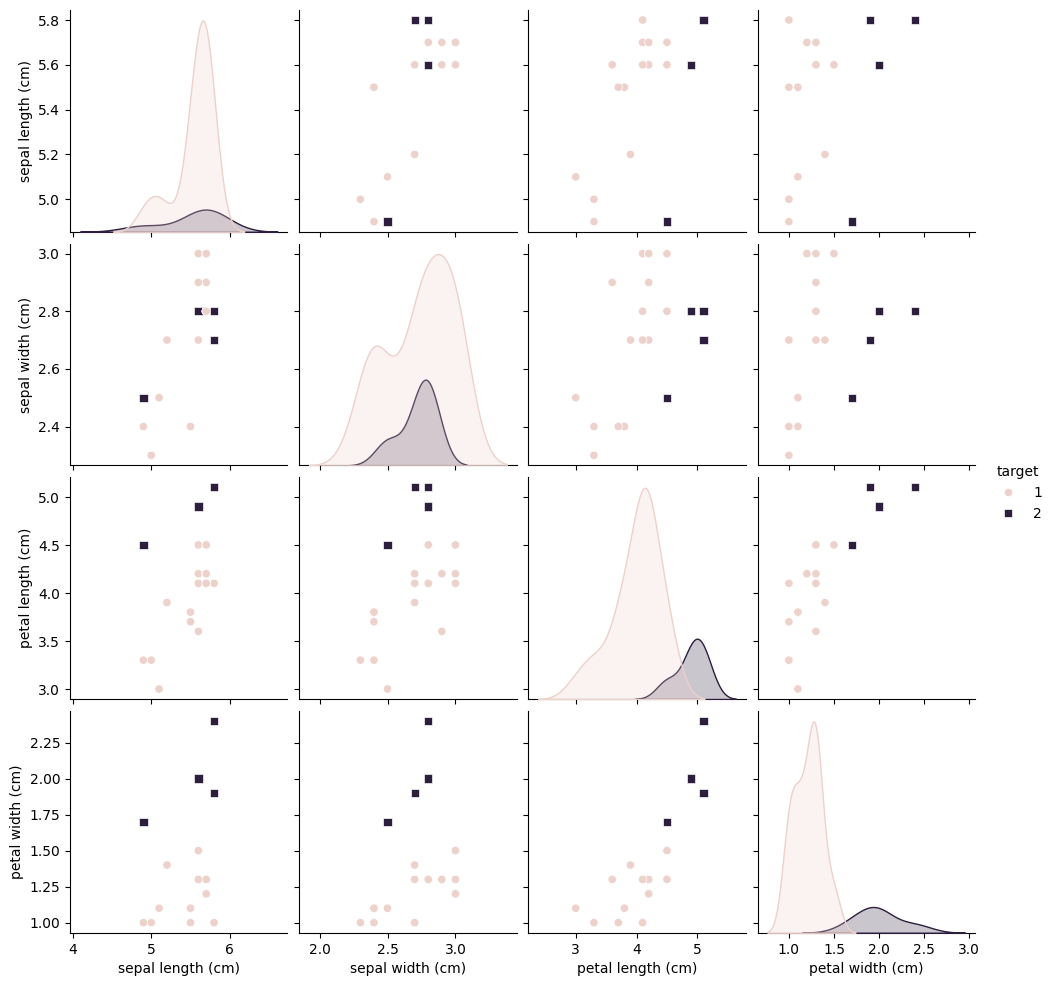

In [33]:
sns.pairplot(bootstrap_sample, hue='target', markers=["o", "s"])
plt.show()

In [34]:
# Separate features and target
X = bootstrap_sample.drop(columns=['target'])
y = bootstrap_sample['target']

# Initialize the Random Forest classifier with the best parameters
rf_classifier = RandomForestClassifier(**best_params['RandomForestClassifier'])

# Fit the model
rf_classifier.fit(X, y)

# Print the fitted model
print(rf_classifier)

RandomForestClassifier(max_depth=5, max_samples=0.8, min_samples_split=5,
                       n_estimators=125, random_state=0)


In [35]:
# Calculate the ROC AUC for the random forest model
roc_auc = roc_auc_score(y, rf_classifier.predict_proba(X)[:, 1])
print("ROC AUC for the random forest model:", roc_auc)

ROC AUC for the random forest model: 1.0


In [36]:
# Separate features and target from the oob_with_excluded dataset
X_val_oob = oob_with_excluded.drop(columns=['target'])
y_val_oob = oob_with_excluded['target']

# Predict probabilities for the validation set
y_val_oob_prob = rf_classifier.predict_proba(X_val_oob)[:, 1]

# Calculate the ROC AUC for the validation set
roc_auc_val_oob = roc_auc_score(y_val_oob, y_val_oob_prob)
print("ROC AUC for the random forest model (OOB with excluded):", roc_auc_val_oob)

ROC AUC for the random forest model (OOB with excluded): 0.9826086956521739
